In [2]:
import re
import torch
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Set device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Read War and Peace file
file = open("./warpeace_input.txt", "r", encoding='utf-8')
text = file.read()

print(f"Original text length: {len(text)} characters")
print("First 100 characters:")
print(text[:100])

Original text length: 3196212 characters
First 100 characters:
"Well, Prince, so Genoa and Lucca are now just family estates of the
Buonapartes. But I warn you, if


In [3]:
text = text.lower()

def clean_text(text):
    text = re.sub(r'(?<!\n)\n(?!\n)', ' ', text)
    lines = text.split('\n')
    cleaned_lines = []
    
    for line in lines:
        cleaned_line = re.sub(r'[^a-zA-Z0-9 \.]', '', line)
        cleaned_lines.append(cleaned_line)
    
    return '\n'.join(cleaned_lines)

text = clean_text(text)
text = re.sub(r'\.', ' . ', text)  # Add spaces around periods
text = re.sub(' +', ' ', text)  

def tokenize(text):
    paragraphs = text.split('\n\n')
    tokens = []
    for para_num, paragraph in enumerate(paragraphs):
        paragraph = paragraph.replace('\n', ' ')
        paragraph = re.sub(' +', ' ', paragraph).strip()
        
        if paragraph:  
            para_tokens = [token for token in paragraph.split(' ') if token != '']
            tokens.extend(para_tokens)
            if para_num < len(paragraphs) - 1:
                next_para = paragraphs[para_num + 1].strip()
                if next_para:
                    tokens.append('<PARA>')
    return tokens

tokens = tokenize(text)

print(f"Token count: {len(tokens)}")
print(f"First 50 tokens: {tokens[:50]}")

Token count: 603376
First 50 tokens: ['well', 'prince', 'so', 'genoa', 'and', 'lucca', 'are', 'now', 'just', 'family', 'estates', 'of', 'the', 'buonapartes', '.', 'but', 'i', 'warn', 'you', 'if', 'you', 'dont', 'tell', 'me', 'that', 'this', 'means', 'war', 'if', 'you', 'still', 'try', 'to', 'defend', 'the', 'infamies', 'and', 'horrors', 'perpetrated', 'by', 'that', 'antichristi', 'really', 'believe', 'he', 'is', 'antichristi', 'will', 'have', 'nothing']


In [4]:
vocabulary = sorted(list(set(tokens)))

wtoi = {ch: i for i, ch in enumerate(vocabulary)}
itow = {i: ch for i, ch in enumerate(vocabulary)}

padding_index = len(wtoi)
wtoi['#'] = padding_index
itow[padding_index] = '#'
block_size = 5

# Recreate training data
X, Y = [], []
context = [wtoi['#']] * block_size

for i, token in enumerate(tokens):
    ix = wtoi[token]
    X.append(context.copy())
    Y.append(ix)
    context = context[1:] + [ix]

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

# Split into training and validation sets (90% train, 10% validation)
split_idx = int(0.9 * len(X))
X_train, X_val = X[:split_idx], X[split_idx:]
Y_train, Y_val = Y[:split_idx], Y[split_idx:]

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Train/Val split: {len(X_train)/len(X)*100:.1f}% / {len(X_val)/len(X)*100:.1f}%")

# Analyze token frequency
from collections import Counter
token_freq = Counter(tokens)
print(f'Size of the vocabulary: {len(vocabulary)}')
print(f"\nMost common tokens: {token_freq.most_common(20)}")

least_common = [(word, count) for word, count in token_freq.items() if count <= 2]
least_common_sorted = sorted(least_common, key=lambda x: x[1])
print(f"\nLeast common tokens: {least_common_sorted[:10]}")

Training samples: 543038
Validation samples: 60338
Train/Val split: 90.0% / 10.0%
Size of the vocabulary: 20069

Most common tokens: [('the', 34394), ('.', 30590), ('and', 22082), ('to', 16636), ('of', 14871), ('<PARA>', 11326), ('a', 10464), ('he', 9808), ('in', 8743), ('his', 7967), ('that', 7798), ('was', 7328), ('with', 5648), ('had', 5354), ('it', 5163), ('her', 4700), ('not', 4638), ('him', 4574), ('at', 4523), ('i', 4075)]

Least common tokens: [('infamies', 1), ('yousit', 1), ('elite', 1), ('scarletliveried', 1), ('10annette', 1), ('grandfathers', 1), ('canceled', 1), ('woundup', 1), ('tease', 1), ('novosiltsevs', 1)]


In [5]:
for i in range(10):
    context_words = ' '.join([itow[idx] for idx in X[i].cpu().numpy()])
    target_word = itow[Y[i].cpu().item()]
    print(f"'{context_words}' -> '{target_word}'")

'# # # # #' -> 'well'
'# # # # well' -> 'prince'
'# # # well prince' -> 'so'
'# # well prince so' -> 'genoa'
'# well prince so genoa' -> 'and'
'well prince so genoa and' -> 'lucca'
'prince so genoa and lucca' -> 'are'
'so genoa and lucca are' -> 'now'
'genoa and lucca are now' -> 'just'
'and lucca are now just' -> 'family'


In [6]:
activation_functions = {
    "tanh": torch.tanh,
    "relu": torch.relu
}

class NextToken(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size_1, hidden_size_2, activation):
        # Initialize the parent class (nn.Module)
        super().__init__()
        
        # Embedding layer
        self.emb = nn.Embedding(vocab_size, emb_dim)
        
        # Hidden layers
        self.lin1 = nn.Linear(block_size * emb_dim, hidden_size_1)
        # Only create second layer if hidden_size_2 > 0
        if hidden_size_2 > 0:
            self.lin2 = nn.Linear(hidden_size_1, hidden_size_2)
            self.lin3 = nn.Linear(hidden_size_2, vocab_size)
        else:
            # Skip to output directly from first hidden layer
            self.lin2 = None
            self.lin3 = nn.Linear(hidden_size_1, vocab_size)
            
        self.activation = activation
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        x = self.activation(self.lin1(x))
        x = self.dropout(x)
        
        if self.lin2 is not None:
            x = self.activation(self.lin2(x))
            
        x = self.lin3(x)
        return x

In [7]:
embedding_dimensions = 32
hidden_size_1 = 1024  
hidden_size_2 = 0
activation = "tanh"
learning_rate = 0.0005

print(f"Context length: {block_size}")
print(f"Embedding dimensions: {embedding_dimensions}")
print(f"Hidden layer sizes: {hidden_size_1}, {hidden_size_2}")
print(f"Activation: {activation}")
print(f"Learning rate: {learning_rate}")

# Initialize model
model = NextToken(
    block_size=block_size,
    vocab_size=len(wtoi),
    emb_dim=embedding_dimensions,
    hidden_size_1=hidden_size_1,
    hidden_size_2=hidden_size_2,
    activation=activation_functions[activation]
).to(device)

Context length: 5
Embedding dimensions: 32
Hidden layer sizes: 1024, 0
Activation: tanh
Learning rate: 0.0005


In [8]:
from tqdm import tqdm

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=learning_rate)
batch_size = 1024  
epochs = 20        
print_every = 5

# Track both training and validation losses
epoch_losses = []
val_losses = []

print(f"Training on: {X_train.shape[0]} samples, Validation on: {X_val.shape[0]} samples")
print(f"Batch size: {batch_size}, Total batches per epoch: {X_train.shape[0] // batch_size}")

epoch_pbar = tqdm(range(epochs), desc="Training Progress", unit="epoch")

for epoch in epoch_pbar:
    # Training
    model.train()
    epoch_loss = 0
    num_batches = 0
    
    for i in range(0, X_train.shape[0], batch_size):
        x = X_train[i:i+batch_size]
        y = Y_train[i:i+batch_size]
        y_pred = model(x) 
        loss = loss_fn(y_pred, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_epoch_loss = epoch_loss / num_batches
    epoch_losses.append(avg_epoch_loss)
    
    # Validation
    model.eval()
    val_loss = 0
    val_batches = 0
    with torch.no_grad():
        for i in range(0, X_val.shape[0], batch_size):
            x_val = X_val[i:i+batch_size]
            y_val = Y_val[i:i+batch_size]
            y_pred_val = model(x_val)
            loss_val = loss_fn(y_pred_val, y_val)
            val_loss += loss_val.item()
            val_batches += 1
    
    avg_val_loss = val_loss / val_batches
    val_losses.append(avg_val_loss)
    
    # Update progress bar with both losses
    epoch_pbar.set_postfix({
        'train_loss': f'{avg_epoch_loss:.4f}',
        'val_loss': f'{avg_val_loss:.4f}',
        'best_val': f'{min(val_losses):.4f}'
    })
    
    if epoch % print_every == 0:
        print(f"\nEpoch {epoch}: Train Loss = {avg_epoch_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

epoch_pbar.close()


Training on: 543038 samples, Validation on: 60338 samples
Batch size: 1024, Total batches per epoch: 530


Training Progress:   5%|▌         | 1/20 [00:21<06:47, 21.44s/epoch, train_loss=6.6949, val_loss=6.2133, best_val=6.2133]


Epoch 0: Train Loss = 6.6949, Val Loss = 6.2133


Training Progress:  30%|███       | 6/20 [02:12<05:14, 22.43s/epoch, train_loss=5.0117, val_loss=6.1025, best_val=6.0692]


Epoch 5: Train Loss = 5.0117, Val Loss = 6.1025


Training Progress:  55%|█████▌    | 11/20 [04:07<03:25, 22.85s/epoch, train_loss=4.4763, val_loss=6.3152, best_val=6.0692]


Epoch 10: Train Loss = 4.4763, Val Loss = 6.3152


Training Progress:  80%|████████  | 16/20 [06:02<01:31, 22.90s/epoch, train_loss=4.2451, val_loss=6.4717, best_val=6.0692]


Epoch 15: Train Loss = 4.2451, Val Loss = 6.4717


Training Progress: 100%|██████████| 20/20 [07:33<00:00, 22.69s/epoch, train_loss=4.1212, val_loss=6.5612, best_val=6.0692]


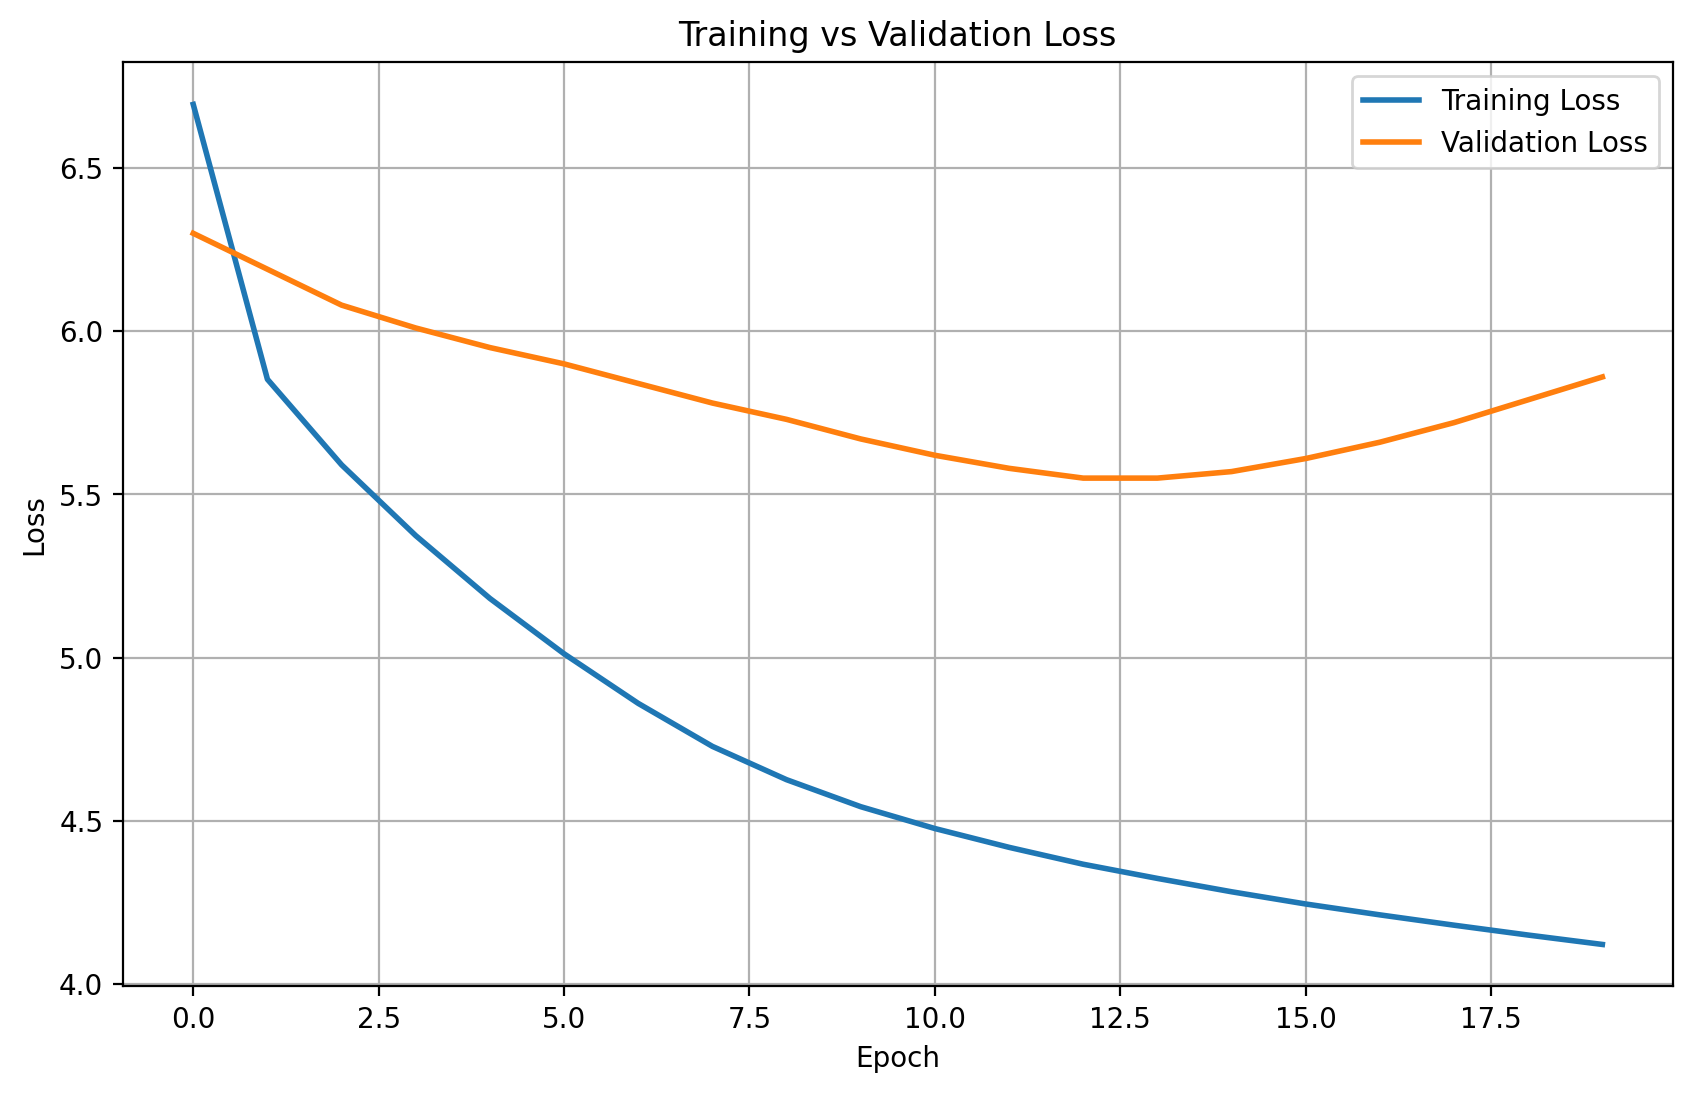

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(epoch_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Our training vs validation loss plot reveals clear overfitting, where training loss steadily decreases over 20 epochs while validation loss begins increasing after just epoch 11. This indicates our model started memorizing the training data rather than learning generalizable patterns.

The widening gap between the two curves shows that while the model became proficient at predicting seen data, its ability to generalize to new text deteriorated quickly. This early overfitting suggests our model architecture, though simplified, still had sufficient capacity to memorize training examples.

In [10]:
# Function to get top predictions for a given context
def get_top_predictions(model, context_words, top_k=5, temperature=0.5):
    model.eval()
    with torch.no_grad():
        # Convert context to indices
        context_indices = [wtoi.get(word, wtoi['#']) for word in context_words.split()]
        if len(context_indices) < block_size:
            context_indices = [wtoi['#']] * (block_size - len(context_indices)) + context_indices
        else:
            context_indices = context_indices[-block_size:]
        
        # Get predictions
        context_tensor = torch.tensor([context_indices]).to(device)
        predictions = model(context_tensor)
        
        # Apply temperature
        predictions = predictions / temperature
        
        # Convert to probabilities
        probabilities = torch.softmax(predictions[0], dim=0)
        
        # Get top-k predictions
        top_probs, top_indices = torch.topk(probabilities, top_k)
        
        results = []
        for prob, idx in zip(top_probs, top_indices):
            word = itow[idx.item()]
            results.append((word, prob.item()))
        
        return results

# Function to generate longer text
def generate_text(model, seed_text, max_length=20, temperature=0.5):
    model.eval()
    generated = seed_text.split()
    
    # Initialize context
    context = [wtoi.get(word, wtoi['#']) for word in generated[-block_size:]]
    if len(context) < block_size:
        context = [wtoi['#']] * (block_size - len(context)) + context
    
    with torch.no_grad():
        for _ in range(max_length):
            context_tensor = torch.tensor([context]).to(device)
            
            # Get predictions
            logits = model(context_tensor)
            logits = logits / temperature
            probs = torch.softmax(logits[0], dim=0)
            
            # Sample from distribution
            next_idx = torch.multinomial(probs, 1).item()
            # next_idx = torch.argmax(probs).item() 

            next_word = itow[next_idx]
            
            # Update
            generated.append(next_word)
            context = context[1:] + [next_idx]
            
            # Stop if we hit natural ending points
            if next_word in ['.', '!', '?', '<PARA>'] and len(generated) > len(seed_text.split()) + 5:
                break
    
    return ' '.join(generated)

In [11]:
# Test contexts that should show different levels of learning
test_contexts = [
    "in the",
    "it was",
    "he was",
    
    # Character names (book-specific)
    "prince",
    "anna pavlovna",
    
    # Longer contexts
    "the prince said",
    "in the room",
    "it was a",
]

print("\nTop Predictions Analysis:")


for context in test_contexts:
    predictions = get_top_predictions(model, context, top_k=3)
    
    print(f"\nContext: '{context}'")
    for i, (word, prob) in enumerate(predictions):
        print(f"  {i+1}. '{word}' ({prob*100:.1f}%)")
    
    # Generate continuation
    continuation = generate_text(model, context, max_length=8, temperature=0.8)
    print(f"  -> Generated: '{continuation}'")


Top Predictions Analysis:

Context: 'in the'
  1. 'dark' (38.5%)
  2. 'darkness' (16.4%)
  3. 'middle' (15.9%)
  -> Generated: 'in the morning the air of soldiers soldiers lighting material'

Context: 'it was'
  1. 'a' (66.6%)
  2. 'the' (11.5%)
  3. 'not' (4.6%)
  -> Generated: 'it was a little feet and though we have been'

Context: 'he was'
  1. 'a' (54.7%)
  2. 'wearing' (9.4%)
  3. 'the' (6.0%)
  -> Generated: 'he was sitting to understand his left at that time'

Context: 'prince'
  1. 'andrew' (53.5%)
  2. 'andrews' (46.3%)
  3. 'vasili' (0.1%)
  -> Generated: 'prince andrew had been carefully in the princess .'

Context: 'anna pavlovna'
  1. 'had' (18.0%)
  2. 'and' (16.3%)
  3. 'was' (13.7%)
  -> Generated: 'anna pavlovna began to speak by them .'

Context: 'the prince said'
  1. 'he' (43.9%)
  2. 'the' (40.5%)
  3. 'pierre' (3.5%)
  -> Generated: 'the prince said the esaul what they were saying the men'

Context: 'in the room'
  1. 'of' (38.2%)
  2. '.' (31.2%)
  3. 'and' (25

In [12]:
# Generate some sample text with different seeds
seeds = [
    "it was", 
    "in the",
    "anna pavlovna",
]

print("\nDifferent temperature settings affect creativity:")

for seed in seeds[:3]:
    print(f"\nSeed: '{seed}'")
    
    print(f"  Temp 0.1: {generate_text(model, seed, temperature=0.1, max_length=15)}")
    print(f"  Temp 0.4: {generate_text(model, seed, temperature=0.4, max_length=15)}")
    print(f"  Temp 0.9: {generate_text(model, seed, temperature=0.9, max_length=15)}")


Different temperature settings affect creativity:

Seed: 'it was'
  Temp 0.1: it was a dark staircase of the forest and the french army the french army had been
  Temp 0.4: it was a warm rainy autumnal of the french and the administration of the french army the
  Temp 0.9: it was necessary to take or think to find well but the count at the council of

Seed: 'in the'
  Temp 0.1: in the dark passage of the forest and the french army .
  Temp 0.4: in the darkness of the french army in the darkness and the french army and the french
  Temp 0.9: in the possibility of their district were always asked pierre he received in a dark wife and

Seed: 'anna pavlovna'
  Temp 0.1: anna pavlovna had been sent to the rearguard and the french soldiers and the french drummer boy
  Temp 0.4: anna pavlovna had been sent to the rearguard and the french soldiers up the french drummer boy
  Temp 0.9: anna pavlovna at last days up in the forest and his arms .


In [13]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

# embeddings
embeddings = model.emb.weight.detach().cpu().numpy()
print(f"Embeddings shape: {embeddings.shape}")  

word_categories = {
    'characters': ['prince', 'anna', 'napoleon', 'pierre', 'andrew', 'natasha', 
                   'vasili', 'mary', 'sonya', 'dolokhov'],
    
    'military': ['war', 'soldier', 'army', 'battle', 'general', 'officer', 
                 'regiment', 'troops', 'enemy', 'victory'],
    
    'emotions': ['love', 'happy', 'sad', 'angry', 'fear', 'joy', 'grief', 
                 'hope', 'despair', 'calm'],
    
    'locations': ['house', 'room', 'city', 'village', 'forest', 'road', 
                  'palace', 'garden', 'street', 'field'],
    
    'time': ['time', 'day', 'night', 'morning', 'evening', 'year', 
             'moment', 'hour', 'week', 'month'],
    
    'family': ['father', 'mother', 'son', 'daughter', 'brother', 'sister',
               'family', 'parents', 'children', 'marriage'],
    
    'verbs': ['said', 'went', 'came', 'saw', 'thought', 'felt', 
              'knew', 'took', 'gave', 'made'],
    
    'adjectives': ['beautiful', 'ugly', 'rich', 'poor', 'young', 'old',
                   'happy', 'sad', 'good', 'bad'],
    
    'pronouns': ['he', 'she', 'they', 'we', 'you', 'i', 'it', 'his', 'her', 'their'],
    
    'prepositions': ['in', 'on', 'at', 'with', 'from', 'to', 'by', 'for', 'of', 'about']
}

words_to_plot = []
categories_list = []
for category, words in word_categories.items():
    for word in words:
        if word in wtoi:  
            words_to_plot.append(word)
            categories_list.append(category)

print(f"Total words selected for visualization: {len(words_to_plot)}")

# Get embedding vectors for selected words
word_indices = [wtoi[word] for word in words_to_plot]
selected_embeddings = embeddings[word_indices]

# Apply t-SNE to reduce to 2D
print("Applying t-SNE dimensionality reduction...")
tsne = TSNE(n_components=2, random_state=42, perplexity=15, learning_rate=200)
embeddings_2d = tsne.fit_transform(selected_embeddings)

# Create DataFrame for plotting
df = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'word': words_to_plot,
    'category': categories_list
})

fig = px.scatter(df, x='x', y='y', text='word', color='category',
                 title='Word Embeddings Visualization (t-SNE)',
                 hover_data=['word', 'category'],
                 width=800, height=600)

fig.update_traces(textposition='top center', marker=dict(size=8))
fig.show()

Embeddings shape: (20070, 32)
Total words selected for visualization: 100
Applying t-SNE dimensionality reduction...


Our t-SNE visualization of word embeddings shows scattered points without clear semantic clustering. This outcome is primarily due to our model's limited training - we only trained for 20 epochs, which wasn't sufficient for the embeddings to develop meaningful semantic relationships.

**Several factors contributed to this:**
- Our relatively simple model architecture with just one hidden layer and 32-dimensional embeddings lacked the capacity to capture complex word relationships
- The training was cut short by overfitting, with validation loss increasing after just 11 epochs, preventing proper embedding learning
- The embeddings didn't have enough training time to organize themselves in the semantic space

In short, our model learned to predict next words at a surface level but didn't develop the deep semantic understanding needed for embedding clusters within this limited training.

In [16]:
from tqdm import tqdm

# Train multiple model variants
def train_model_variant(variant_name, block_size, emb_dim, hidden_size):
    print(f"Training {variant_name} variant...")
    
    # Recreate training data with current block_size
    X, Y = [], []
    context = [wtoi['#']] * block_size

    for i, token in enumerate(tokens):
        ix = wtoi[token]
        X.append(context.copy())
        Y.append(ix)
        context = context[1:] + [ix]

    X = torch.tensor(X).to(device)
    Y = torch.tensor(Y).to(device)
    
    # Split into train/validation (90-10 split)
    split_idx = int(0.9 * len(X))
    X_train, X_val = X[:split_idx], X[split_idx:]
    Y_train, Y_val = Y[:split_idx], Y[split_idx:]

    # Model setup
    model = NextToken(block_size, len(wtoi), emb_dim, hidden_size, 0, torch.tanh).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()
    
    batch_size = 1024
    best_val_loss = float('inf')
    
    # Training loop with tqdm
    epoch_pbar = tqdm(range(10), desc=f"Training {variant_name}")
    
    for epoch in epoch_pbar:
        # Training
        model.train()
        epoch_train_loss = 0
        num_batches = 0
        
        for i in range(0, X_train.shape[0], batch_size):
            x_batch = X_train[i:i+batch_size]
            y_batch = Y_train[i:i+batch_size]
            
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            epoch_train_loss += loss.item()
            num_batches += 1
        
        avg_train_loss = epoch_train_loss / num_batches
        
        # Validation
        model.eval()
        epoch_val_loss = 0
        val_batches = 0
        
        with torch.no_grad():
            for i in range(0, X_val.shape[0], batch_size):
                x_val = X_val[i:i+batch_size]
                y_val = Y_val[i:i+batch_size]
                
                y_pred_val = model(x_val)
                loss_val = loss_fn(y_pred_val, y_val)
                epoch_val_loss += loss_val.item()
                val_batches += 1
        
        avg_val_loss = epoch_val_loss / val_batches
        
        # Update progress bar
        epoch_pbar.set_postfix({
            'train_loss': f'{avg_train_loss:.4f}',
            'val_loss': f'{avg_val_loss:.4f}',
            'best_val': f'{best_val_loss:.4f}'
        })
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'model_state': model.state_dict(),
                'wtoi': wtoi,
                'itow': itow,
                'block_size': block_size,
                'emb_dim': emb_dim,
            }, f'models/model_{variant_name}.pth')
    
    print(f"\n{variant_name} completed! Best val loss: {best_val_loss:.4f}\n")
    return model

# Create models directory
import os
if not os.path.exists('models'):
    os.makedirs('models')

# Train variants
variants = {
    'small': {'block_size': 3, 'emb_dim': 32, 'hidden_size': 256},
    'medium': {'block_size': 5, 'emb_dim': 64, 'hidden_size': 512},
    'large': {'block_size': 8, 'emb_dim': 64, 'hidden_size': 1024}
}

print("Starting training for all model variants...")
for name, params in variants.items():
    train_model_variant(name, **params)
    print("-" * 50)

Starting training for all model variants...
Training small variant...


Training small: 100%|██████████| 10/10 [01:14<00:00,  7.46s/it, train_loss=5.0327, val_loss=5.9177, best_val=5.8913]



small completed! Best val loss: 5.8913

--------------------------------------------------
Training medium variant...


Training medium: 100%|██████████| 10/10 [02:07<00:00, 12.80s/it, train_loss=4.3322, val_loss=6.0931, best_val=5.8988]



medium completed! Best val loss: 5.8988

--------------------------------------------------
Training large variant...


Training large: 100%|██████████| 10/10 [03:54<00:00, 23.49s/it, train_loss=3.7974, val_loss=6.6189, best_val=6.0257]


large completed! Best val loss: 6.0257

--------------------------------------------------
